In [1]:
# pip install numpy scikit-learn matplotlib seaborn mesa

# Juego de la Vida (Game of Life)
El **Juego de la Vida**, también conocido como **Vida**, es un autómata celular diseñador por el matemático británico John Horton Conway en 1970. Es un juego sin jugadores, esto significa que su evolución está determinada por su estado inicial, sin requerir más entradas. Uno interactúa con el Juego de la Vida al crear un estado inicial (o configuración inicial) y se observa como evoluciona. Es Turing completo (puede simular cualquier máquina de Turing) y puede simular un constructor universal o cualquier otra máquina de Turing.
<center>
<img src="https://1.bp.blogspot.com/-pdQ2ckeQzCw/WwGFbYTKRoI/AAAAAAAAAY8/kb-gcutnkKc2TnQainAlYK5FlWmv87XywCPcBGAYYCw/s1600/ezgif.com-video-to-gif.gif" width=250 height=250 />
</center>

## Reglas

El universo (o entorno) del Juego de la Vida es infinito, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra con uno de dos posibles estados, vivo o muerto (o poblado o despoblado, respectivamente). Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier celda viva con menos de dos vecinos vivos muere, debido a la poca población.
2. Cualquier celda viva con dos o tres vecinos vivos sobrevive para la siguiente generación.
3. Cualquier celda con más de tres vecinos vivos muere, debido a sobre población.
4. Cualquier celda muerta con exactamente tres vecinos vivos se convierte en una celda viva, debido a la reproducción.

Estas reglas, que comparan el comportamiento del autómata a la vida real, pueden ser condensadas en lo siguiente:

1. Cualquier celda viva con dos o más vecinos vivos sobrevive.
2. Cualquier celda muerta con tres vecinos vivos se convierte en una celda viva.
3. Cualquier otra celda viva muere en la siguiente generación. De manera similar, cualquier otra celda muerta se queda muerta.

El patrón inicial constituye la semilla del sistema. La primera generación es creada al aplicar las reglas anteriores de manera simultanea a cualquier celda en la semilla, viva o muerta; nacimientos y muertes ocurren simultáneamente, y el momento discreto en el cual esto pasa es a veces llamado turno. Cada generación es una función pura de la anterior. Las reglas se aplican de forma repetida para crear nuevas generaciones.

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.
- `seaborn`: para agregar más colores.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model # AGENTE: entidad que trabaja
                              # MODELO: espacio donde conviven los agentes (sistema)

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid # Un agente por celda

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation # Para que tomen la decisión a la vez

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector # DICCIONARIO: Colecta los datos

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np  # Matrices...
import pandas as pd # Manejo de datos (dataframes)

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [3]:
class Cell(Agent):
    def __init__ (self, id, model):
        super().__init__(id, model) # PARAMETROS MÍNIMOS: id, modelo
        self.live = np.random.choice([0, 1]) # Elige al azar si está viva o muerta
        self.next_state = None
    
    # 1.    step()  Definir en qué estado queda
    # 2. advance()  Teniendo la definición de todas, cambio a ese estado
    # De esta manera la decisión de un agente no impacta en el de otro

    def step(self):
        # ¿Cuántos vecinos hay? (vector)
            # sistema.espacio.dame_vecinos(miPos, moore = (True | False [von Newmann]), teIncluye = T|F)
                #    Modelo de moore: todos los de alrededor
                # Modelo von Newmann: arriba, abajo, izq, der
        neighbors = self.model.grid.get_neighbors(self.pos,
                                                   moore = True,
                                                   include_center = False)
        count = 0
        for agent in neighbors:
            count = count + agent.live # (1: alive | 0: dead)

        self.next_state = self.live
        
        if self.next_state == 1:
            if count < 2 or count > 3: # Soledad or Sobrepoblación
                self.next_state = 0
        else:
            if count == 3:
                self.next_state = 1 # Reproducción

    def advance(self):
        self.live = self.next_state

In [4]:
# Función para recopilar la información a almacenar en el data collector
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    
    for (content, (x, y)) in model.grid.coord_iter():
        grid[x][y] = content.live
        
    return grid

In [5]:
class GameOfLifeModel(Model): 
    def __init__(self, width, height):
        self.grid = SingleGrid(width, height, torus = True) # Definir el espacio |  torus ¿el de arriba se conecta con el de abajo?
        self.schedule = SimultaneousActivation(self) # Definir el modo de activacion

        for (content, (x, y)) in self.grid.coord_iter():
            agent = Cell((x, y), self) # Creamos el agente con un id y el ambiente
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

        self.datacollector = DataCollector(model_reporters = {
            "Grid" : get_grid}) 

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
GRID_SIZE = 20
MAX_GENERATIONS = 200

model = GameOfLifeModel(GRID_SIZE, GRID_SIZE)
for i in range (MAX_GENERATIONS):
    model.step()

In [7]:
all_grid = model.datacollector.get_model_vars_dataframe() # Arreglo de matrices

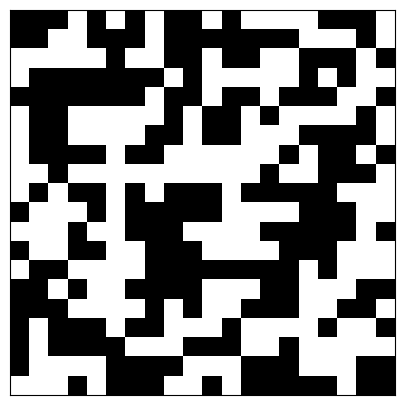

In [8]:
fig, axis = plt.subplots(figsize = (5, 5)) # 5x5 pulgadas
axis.set_xticks([])
axis.set_yticks([])

patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames = MAX_GENERATIONS)

In [9]:
anim